![](https://res.cloudinary.com/dn1j6dpd7/image/fetch/f_auto,q_auto,w_736/https://www.livechat.com/wp-content/uploads/2016/04/customer-churn@2x.jpg)
<i>Image Source:</i> [What Is Churn Rate and Why It Will Mess With Your Growth](https://www.livechat.com/success/churn-rate/)

## 1. Introduction
Customer Churn is when customers leave a service in a given period of time, which is bad for business.<br>
This work has as objective to build a machine learning model to predict what customers will leave the service, the dataset used on this notebook is the [Telco Customer Churn](https://www.kaggle.com/blastchar/telco-customer-churn) hosted at Kaggle. Also, an Exploratory Data Analysis is made to a better understand about the data. 
Another point on this work is use Deepnote as development enviroment and the [PyCaret](https://pycaret.org/) Python Module to make all the experiment pipeline. 

### 1.1 Enviroment Setup
The Modules used for this work, highlights for PyCaret and good plots by [Plotly](https://plotly.com/).

In [ ]:
# Standard
import pandas as pd
import numpy as np
# Pycaret
from pycaret.classification import *
# Plots
from plotly.offline import iplot
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import seaborn as sns
# Sklearn tools
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
# Extras
from datetime import date
import warnings
warnings.filterwarnings("ignore")
# Datapath and Setup
data_path = "/datasets/telco-customer-churn/"
random_seed = 142

And the helper functions used on this notebook.

In [ ]:
# Helper functions for structured data
## Get info about the dataset
def dataset_info(dataset, dataset_name: str):
    print(f"Dataset Name: {dataset_name} | Number of Samples: {dataset.shape[0]} | Number of Columns: {dataset.shape[1]}")
    print(30*"=")
    print("Column             Data Type")
    print(dataset.dtypes)
    print(30*"=")
    missing_data = dataset.isnull().sum()
    if sum(missing_data) > 0:
        print(missing_data[missing_data.values > 0])
    else:
        print("No Missing Data on this Dataset!")
    print(30*"=")
    print(f"Memory Usage: {np.round(dataset.memory_usage(index=True).sum() / 10e5, 3)} MB")
## Dataset Sampling
def data_sampling(dataset, frac: float, random_seed: int):
    data_sampled_a = dataset.sample(frac=frac, random_state=random_seed)
    data_sampled_b =  dataset.drop(data_sampled_a.index).reset_index(drop=True)
    data_sampled_a.reset_index(drop=True, inplace=True)
    return data_sampled_a, data_sampled_b   
## Bar Plot
def bar_plot(data, plot_title: str, x_axis: str, y_axis: str):
    colors = ["#0080ff",] * len(data)
    colors[0] = "#ff8000"
    trace = go.Bar(y=data.values, x=data.index, text=data.values, 
                    marker_color=colors)
    layout = go.Layout(autosize=False, height=600,
                    title={"text" : plot_title,
                       "y" : 0.9,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"},  
                    xaxis={"title" : x_axis},
                    yaxis={"title" : y_axis},)
    fig = go.Figure(data=trace, layout=layout)
    fig.update_layout(template="simple_white")
    fig.update_traces(textposition="outside",
                    textfont_size=14,
                    marker=dict(line=dict(color="#000000", width=2)))                
    fig.update_yaxes(automargin=True)
    iplot(fig)
## Plot Pie Chart
def pie_plot(data, plot_title: str):
    trace = go.Pie(labels=data.index, values=data.values)
    layout = go.Layout(autosize=False,
                    title={"text" : plot_title,
                       "y" : 0.9,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"})
    fig = go.Figure(data=trace, layout=layout)
    fig.update_traces(textfont_size=14,
                    marker=dict(line=dict(color="#000000", width=2)))
    fig.update_yaxes(automargin=True)            
    iplot(fig)
## Histogram
def histogram_plot(data, plot_title: str, y_axis: str):
    trace = go.Histogram(x=data)
    layout = go.Layout(autosize=False,
                    title={"text" : plot_title,
                       "y" : 0.9,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"},  
                    yaxis={"title" : y_axis})
    fig = go.Figure(data=trace, layout=layout)
    fig.update_traces(marker=dict(line=dict(color="#000000", width=2)))
    fig.update_layout(template="simple_white")
    fig.update_yaxes(automargin=True)
    iplot(fig)
# Particular case: Histogram subplot (1, 2)
def histogram_subplot(dataset_a, dataset_b, feature_a: str,
                        feature_b: str, title: str, title_a: str, title_b: str):
    fig = make_subplots(rows=1, cols=2, subplot_titles=(
                        title_a,
                        title_b
                        )
                    )
    fig.add_trace(go.Histogram(x=dataset_a[feature_a], showlegend=False), row=1, col=1)
    fig.add_trace(go.Histogram(x=dataset_b[feature_b], showlegend=False), row=1, col=2)
    fig.update_layout(template="simple_white")
    fig.update_layout(autosize=False,
                        title={"text" : title,
                        "y" : 0.9,
                        "x" : 0.5,
                        "xanchor" : "center",
                        "yanchor" : "top"},  
                        yaxis={"title" : "<i>Frequency</i>"})
    fig.update_traces(marker=dict(line=dict(color="#000000", width=2)))
    fig.update_yaxes(automargin=True)
    iplot(fig)
# Calculate scores with Test/Unseen labeled data
def test_score_report(data_unseen, predict_unseen):
    le = LabelEncoder()
    data_unseen["Label"] = le.fit_transform(data_unseen.Churn.values)
    data_unseen["Label"] = data_unseen["Label"].astype(int)
    accuracy = accuracy_score(data_unseen["Label"], predict_unseen["Label"])
    roc_auc = roc_auc_score(data_unseen["Label"], predict_unseen["Label"])
    precision = precision_score(data_unseen["Label"], predict_unseen["Label"])
    recall = recall_score(data_unseen["Label"], predict_unseen["Label"])
    f1 = f1_score(data_unseen["Label"], predict_unseen["Label"])

    df_unseen = pd.DataFrame({
        "Accuracy" : [accuracy],
        "AUC" : [roc_auc],
        "Recall" : [recall],
        "Precision" : [precision],
        "F1 Score" : [f1]
    })
    return df_unseen
# Confusion Matrix
def conf_mat(data_unseen, predict_unseen):
    unique_label = data_unseen["Label"].unique()
    cmtx = pd.DataFrame(
        confusion_matrix(data_unseen["Label"], predict_unseen["Label"], labels=unique_label), 
        index=['{:}'.format(x) for x in unique_label], 
        columns=['{:}'.format(x) for x in unique_label]
    )
    ax = sns.heatmap(cmtx, annot=True, fmt="d", cmap="YlGnBu")
    ax.set_ylabel('Predicted')
    ax.set_xlabel('Target');
    ax.set_title("Predict Unseen Confusion Matrix", size=14);

## 2. Load Data

The Dataset is load as a Pandas dataframe and show a gimplse of the data.
A good thing about Deepnote is that the displayed dataframes shows the column type, helping to understand the features.

In [ ]:
dataset = pd.read_csv(data_path+"customers.csv")
dataset.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


Check for duplicated samples.

In [ ]:
dataset[dataset.duplicated()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


Is needed so more information about the dataset as the number of samples, memory size allocation, etc.<br>
The result is showed on the following output (The Data Type is just showed for convenience, to make this notebook useful on other enviroments).

In [ ]:
dataset_info(dataset, "customers")

Dataset Name: customers | Number of Samples: 7043 | Number of Columns: 21
Column             Data Type
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
No Missing Data on this Dataset!
Memory Usage: 1.183 MB


The dataset has a small memory size allocation (1.183 MB) and is composed for many Categorical (object) features and only a few numeric, but one of the categorical features doesn't look right, the `TotalCharges`, as showed on the displayed dataframe, the festure is numeric.<br>
`TotalCharges` is converted from Object to float64, the same of `MonthlyCharges` feature.

In [ ]:
dataset["TotalCharges"] = pd.to_numeric(dataset["TotalCharges"], errors="coerce")
print(f"The Feature TotalCharges is type {dataset.TotalCharges.dtype} now!")

The Feature TotalCharges is type float64 now!


## 3. Exploratory Data Analysis

### 3.1 Churn Distribution
The Client Churn Distribution is checked for any imbalance, as the feature is the target, it's important to choose what strategy to adopt when dealing with imbalanced classes.<br>
Below, a Pie Chart shows the feature distribution.


In [ ]:
pie_plot(dataset["Churn"].value_counts(), plot_title="<b>Client Churn Distribution<b>")

There's some imbalance on Churn Distribution, 26.5% of the clients have churned, and small occurences of a label could lead to bad predictor.<br>
It's possible to choose some ways to work with this case:
* Make a random over-sampling, duplicating some samples of the minority class until this reach a balance, but this could lead to an overfitted model.
* Make a random down-sampling, removing some samples from the majority class until this reach a balance, but this leads to information loss and not feeding the model with the collected samples.
* Make a random down-sampling, removing some samples from the majority class until this reach a balance, but this leads to information loss and not feeding the model with the collected samples.
* Another resampling technique, as SMOTE.
* Choosing a metric that deals with imbalanced datasets, like F1 Score.

The Churn problem is about client retention, so is worth to check about false positives, so precision and recall metrics are a must for this situtation.<br>
F1 Score is used to check the quality of the model predictions, as the metric is an harmonic mean of precision and recall. 

### 3.2 Analysis of the Contract Type


The contract type is a good feature to analyze what happens to a client churn from that service, a plot from the contract types of not churned clients is showed below.

In [ ]:
df_aux = dataset.query('Churn == "No"')
df_aux = df_aux["Contract"].value_counts()
bar_plot(df_aux, "<b>Contract Types of not Churned Clients</b>", "<i>Contract</i>", "<i>Count</i>")

Is showed that a Month-to-month contract is the firts when compared to annual contracts, but the difference between the number of contracts is not so big.<br>
To a better comparation, the same plot is showed for the churned clients.

In [ ]:
df_aux = dataset.query('Churn == "Yes"')
df_aux = df_aux["Contract"].value_counts()
bar_plot(df_aux, "<b>Contract Types of Churned Clients</b>", "<i>Contract</i>", "<i>Count</i>")

Now, the difference between a Month-to-month and annual contractts is bigger, and can lead to a conclusion that annual contracts are better to retain the clients, perhaps fidelity promotions could aid to reduce the churn rate.<br>
As the problem can be examined more deep on Month-to-month contract types, a good idea is see the Monthly Charges and Total Charges distribution for the not churned clients of this contract.


In [ ]:
df_aux = dataset.query('(Contract == "Month-to-month") and (Churn == "No")')
histogram_subplot(df_aux, df_aux, "MonthlyCharges", "TotalCharges", "<b>Charges Distribution for Month-to-month contracts for not Churned Clients</b>",
                "(a) Monthtly Charges Distribution", "(b) Total Charges Distribution")

From the plots, can be said that many clients just got charged with a few values, principally for the Total Charges.<br>
On the following plots, the same features are analyzed, but for churned clients.

In [ ]:
df_aux = dataset.query('(Contract == "Month-to-month") and (Churn == "Yes")')
histogram_subplot(df_aux, df_aux, "MonthlyCharges", "TotalCharges", "<b>Charges Distribution for Month-to-month contracts for Churned Clients</b>",
                "(a) Monthtly Charges Distribution", "(b) Total Charges Distribution")

Total Charges had the same behaviour, but the Monthly Charges for many churned clients was high, maybe the amount of chage value could lead the client to leave the service.<br>
Still on the Month-to-month contract, it's time to analyze the most used Payment methods of churned clients.

In [ ]:
df_aux = dataset.query(('Contract == Month-to-month') and ('Churn == "Yes"'))
df_aux = df_aux["PaymentMethod"].value_counts()
bar_plot(df_aux, "<b>Payment Method of Month-to-month contract Churned Clients</b>", "<i>Payment Method</i>", "<i>Count</i>")

Many Churned Clients used to pay with electronic checks, automatic payments, as bank transfers or credit card have a few churned clients. A good idea could make promotions to clients that use automatic payment methods. <br>
Lastly, the tenure of the churned clients.

In [ ]:
df_aux = dataset.query(('Contract == Month-to-month') and ('Churn == "Yes"'))
df_aux = df_aux["tenure"].value_counts().head(5)
bar_plot(df_aux, "<b>Tenure of Month-to-month contract for Churned Clients</b>", "<i>Tenure</i>", "<i>Count</i>")

Most clients just used the service for one month, seems like the clients used to service to check the quality or the couldn't stay for the amount of charges, as the Monthly Charges for these clients was high and the Total Charges was small, as the client just stayed a little time.  

## 4. Setting up PyCaret

Before setting up PyCaret, a random sample of 10% size of the dataset will be get to make predictions with unseen data. 

In [ ]:
data, data_unseen = data_sampling(dataset, 0.9, random_seed)
print(f"There are {data_unseen.shape[0]} samples for Unseen Data.")

There are 704 samples for Unseen Data.


The PyCaret's setup is made with 90% of data samples and just use one function (`setup`) from the module.<br>
It's possible configure with variuos options, as data pre-processing, feature engineering, etc. The easy and efficient of PyCaret buy a lot of time when prototyping models.<br>
Each setup is an experiment and for this problem, is used the following options:
* Normalization of the numerical features with Z-Score.
* Feature Selection with permutation importance techniques.
* Outliers Removal.
* Features Removal based on Multicollinearity.
* Features Scalling Transformation.
* Ignore low variance on Features.
* PCA for Dimensionality Reduction, as the dataset has many features.
* Numeric binning on the features `MonthlyCharges` and `TotalCharges`.
* 70% of samples for Train and 30% for test.

In [ ]:
exp01 = setup(data=data, target="Churn", session_id=random_seed, ignore_features=["customerID"], 
                numeric_features=["SeniorCitizen"], normalize=True,
                feature_selection=True, remove_outliers=True, remove_multicollinearity=True,
                transformation=True, ignore_low_variance=True, pca=True, 
                bin_numeric_features=["MonthlyCharges", "TotalCharges"])

 
Setup Succesfully Completed!


,Description,Value
0,session_id,142
1,Target Type,Binary
2,Label Encoded,"No: 0, Yes: 1"
3,Original Data,"(6339, 21)"
4,Missing Values,True
5,Numeric Features,4
6,Categorical Features,16
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


PyCaret shows at first if all features types are with it correspondent type, if everything is right, press enter on the blank bar and the setup is finished showing a summary of the experiment. 

## 5. Model Build

A great tool on PyCaret is build many models and compare a metric for the bests! <br>
Due the target class imbalance, the models are sorted by F1 Score.

In [ ]:
compare_models(fold=10, sort="F1")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Quadratic Discriminant Analysis,0.758,0.8187,0.7187,0.5493,0.6223,0.4492
1,Logistic Regression,0.8024,0.8391,0.5583,0.6742,0.61,0.4793
2,Linear Discriminant Analysis,0.7967,0.8342,0.566,0.6551,0.6063,0.4703
3,Gradient Boosting Classifier,0.7957,0.8331,0.5377,0.6621,0.5929,0.4586
4,Ridge Classifier,0.7995,0,0.5154,0.6841,0.5869,0.4581
5,Extreme Gradient Boosting,0.7929,0.8317,0.5275,0.6582,0.5847,0.4491
6,Light Gradient Boosting Machine,0.7886,0.8184,0.5249,0.6468,0.5784,0.4395
7,Naive Bayes,0.7582,0.784,0.5917,0.5603,0.5751,0.4065
8,CatBoost Classifier,0.7893,0.8253,0.5077,0.6563,0.5717,0.435
9,Ada Boost Classifier,0.7791,0.8177,0.518,0.6218,0.5643,0.4182


The best model suggested by PyCaret is the Quadratic Discriminant Analysis (QDA), with a F1 Score around 0.6 and a good Recall, around 0.7.<br>
Let's stick with QDA and create the model.

In [ ]:
base_alg = "qda"
base_model = create_model(base_alg)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8033,0.8467,0.7607,0.6181,0.6820,0.5418
1,0.7607,0.8413,0.7350,0.5513,0.6300,0.4584
2,0.7346,0.7878,0.6496,0.5170,0.5758,0.3863
3,0.7654,0.8226,0.7265,0.5592,0.6320,0.4640
4,0.7820,0.8436,0.7350,0.5850,0.6515,0.4959
5,0.7173,0.7859,0.7009,0.4940,0.5795,0.3761
6,0.7672,0.8069,0.7414,0.5584,0.6370,0.4707
7,0.7245,0.8117,0.7069,0.5000,0.5857,0.3883
8,0.7815,0.8470,0.7155,0.5845,0.6434,0.4882
9,0.7435,0.7940,0.7155,0.5253,0.6058,0.4222


And see the hyper-parameters used for build the base model.

In [ ]:
plot_model(base_model, plot="parameter")

,Parameters
priors,None
reg_param,0
store_covariance,False
tol,0.0001


It's possible to tune the base model and optmize a metric, for this case, F1 Score.

In [ ]:
tuned_model = tune_model(base_alg, fold=10, optimize="F1")

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7962,0.8600,0.7607,0.6054,0.6742,0.5287
1,0.7820,0.8552,0.7521,0.5828,0.6567,0.5007
2,0.7464,0.7882,0.6923,0.5329,0.6022,0.4207
3,0.7630,0.8245,0.7350,0.5548,0.6324,0.4625
4,0.7962,0.8540,0.7692,0.6040,0.6767,0.5310
5,0.7340,0.8072,0.7863,0.5140,0.6216,0.4300
6,0.7720,0.8246,0.7414,0.5658,0.6418,0.4789
7,0.7387,0.8243,0.7328,0.5183,0.6071,0.4199
8,0.7601,0.8379,0.6983,0.5510,0.6160,0.4450
9,0.7720,0.8282,0.7414,0.5658,0.6418,0.4789


There's an improvement from the base model on F1 Score! Now, time to see what hyper-parameters were used by the tuned model.

In [ ]:
plot_model(tuned_model, plot="parameter")

,Parameters
priors,None
reg_param,0.25
store_covariance,False
tol,0.0001


The `reg_param` was higher on the tuned model.<br>
The Only problem with using QDA is that not possible to get the Features Importance plot of the model, but the model is used as some good insights about the data were got on the EDA.<br> 
PyCaret also has functions to make ensembles, for this implementation, a bagged model is build.

In [ ]:
bagged_model = ensemble_model(tuned_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7986,0.8583,0.7692,0.6081,0.6792,0.5354
1,0.7796,0.8543,0.7521,0.5789,0.6543,0.4965
2,0.7512,0.7868,0.7009,0.5395,0.6097,0.4316
3,0.7630,0.8229,0.7350,0.5548,0.6324,0.4625
4,0.7915,0.8534,0.7692,0.5960,0.6716,0.5224
5,0.7387,0.8082,0.7949,0.5196,0.6284,0.4402
6,0.7672,0.8254,0.7328,0.5592,0.6343,0.4681
7,0.7411,0.8238,0.7500,0.5210,0.6148,0.4292
8,0.7577,0.8380,0.6983,0.5473,0.6136,0.4409
9,0.7743,0.8284,0.7414,0.5695,0.6442,0.4831


The bagged model improved a bit the F1 Score, it's also possible make blended and stacked models with PyCaret, both models are created using the the tuned and bagged models with the soft method.

In [ ]:
blended_model = blend_models(estimator_list=[tuned_model, bagged_model], method="soft")

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7962,0.8592,0.7607,0.6054,0.6742,0.5287
1,0.7796,0.8546,0.7521,0.5789,0.6543,0.4965
2,0.7512,0.7881,0.7009,0.5395,0.6097,0.4316
3,0.7630,0.8235,0.7350,0.5548,0.6324,0.4625
4,0.7938,0.8532,0.7692,0.6000,0.6742,0.5267
5,0.7387,0.8077,0.7949,0.5196,0.6284,0.4402
6,0.7743,0.8255,0.7414,0.5695,0.6442,0.4831
7,0.7411,0.8238,0.7414,0.5212,0.6121,0.4265
8,0.7601,0.8379,0.6983,0.5510,0.6160,0.4450
9,0.7720,0.8286,0.7414,0.5658,0.6418,0.4789


In [ ]:
stacked_model = stack_models([tuned_model, bagged_model], method="soft")

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8246,0.8591,0.5897,0.7263,0.6509,0.5355
1,0.8199,0.8665,0.5897,0.7113,0.6449,0.5256
2,0.7773,0.8215,0.5128,0.6186,0.5607,0.4133
3,0.7749,0.8354,0.4957,0.6170,0.5498,0.4021
4,0.8128,0.8569,0.5470,0.7111,0.6184,0.4971
5,0.7815,0.8302,0.6068,0.6068,0.6068,0.4555
6,0.8052,0.8279,0.5431,0.6848,0.6058,0.4787
7,0.8314,0.8282,0.5948,0.7419,0.6603,0.5499
8,0.8124,0.8442,0.5431,0.7079,0.6146,0.4934
9,0.7815,0.8231,0.5259,0.6224,0.5701,0.4250


Although the stacked model had improved precision on a good amount, the blended still got a better F1 and it is saved as the best model.<br>
This model is saved and its ROC Curves are plotted below. 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


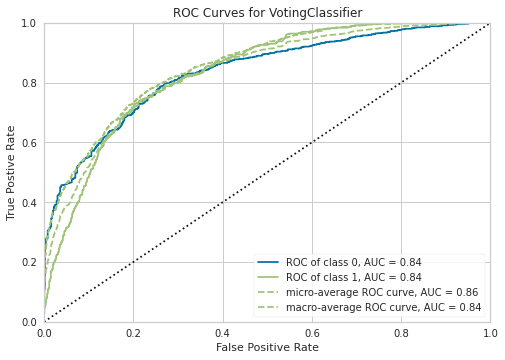

In [ ]:
best_model = blended_model
plot_model(best_model, plot="auc")

## 6. Prediction on Test Data

The test is made with the remaining 30% of data that PyCaret got on the setup, it's important to see that the model is not overfitting.

In [ ]:
predict_model(best_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Voting Classifier,0.7709,0.8352,0.742,0.5655,0.6419,0.4779


As everything is right with the model, it's time to finalize it fitting all the data.

In [ ]:
final_model = finalize_model(best_model)

## 7. Prediction on Unseen Data

The remaining 10% data is used to make predictions with unseen samples, what could include some outliers, it's how real world data works.<br>
Just Kappa Score is not showed, as the focus is the F1 Score.<br>
It's not necessary to make any transformation on the data, PyCaret do this.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
 Accuracy       AUC    Recall  Precision  F1 Score
 0.792614  0.796375  0.803571   0.544355  0.649038


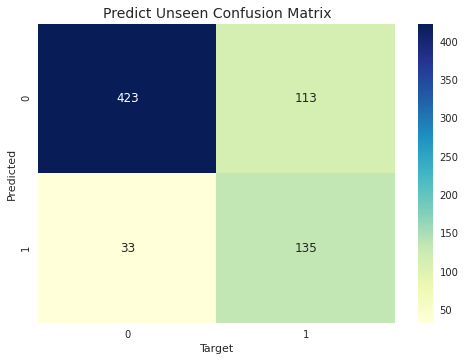

In [ ]:
predict_unseen = predict_model(final_model, data=data_unseen);
score_unseen = test_score_report(data_unseen, predict_unseen)
print(score_unseen.to_string(index=False))
conf_mat(data_unseen, predict_unseen);

And the Unseen Data predicts as the trained model! The model was sucessful built! 

## 8. Save Experiment and Model

PyCaret allows to save all the pipeline experiment and the model to deploy.<br>
It's recommended to save with date of the experiments.

In [ ]:
save_experiment("expQDA_"+date.today().strftime("%m-%d-%Y"))
save_model(tuned_model, "modelQDA_"+date.today().strftime("%m-%d-%Y"))

Experiment Succesfully Saved
Transformation Pipeline and Model Succesfully Saved


## 9. Conclusion

From the results and explanations presented here, some conclusion can be draw:
* The type of contract has a strict relationship with churned clients, Month-to-month contracts with high amount of charges could lead a client to leave the service.
* For the predictions made by the model and based on the precision and recall scores, as F1 Score try to show a balance between these two metrics, the precision was near 54%, what means that the model predict correctly 54% of classified clients as churned, on other hand, the recall was good, where around 80% of the actually churned clients was predict correctly.
* The metrics must be used in favor of the business interests, is needed a more correct prediction of the churned clients or get more a part of these clients?
* One possible way to improve the results is SMOTE as data resampling.

From the tools and enviroment used:
* Deepnote is a fantastic tool to use Python Notebooks, the design is clear, a good variable explorer, an option to publish the notebook as an article, terminal for commands like git, etc.
* PyCaret is incredible, it speed up the model build a lot and the pre-processing is very useful, beyond of the functions to save and deploy the model.

Thanks for you reading!